In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path='/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset'
classes = os.listdir(data_path)
print("Classes:", classes)


Classes: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

In [4]:
img_height, img_width = 150, 150
batch_size = 32

In [5]:
image_paths = []
labels = []

# Loop through each subfolder
for label in classes:
    folder_path = os.path.join(data_path, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        image_paths.append(img_path)
        labels.append(label)

# Create a DataFrame for convenience
data_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [6]:
data_df.head()

,image_path,label
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented


In [7]:
data_df['label'].value_counts()

label
NonDemented         9600
VeryMildDemented    8960
MildDemented        8960
ModerateDemented    6464
Name: count, dtype: int64

In [8]:
# Split the dataset
train_df, val_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 27187
Validation samples: 6797


In [9]:
# Initialize the ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize pixel values
    rotation_range=20,          # Random rotation
    width_shift_range=0.2,      # Horizontal shifts
    height_shift_range=0.2,     # Vertical shifts
    shear_range=0.2,            # Shearing
    zoom_range=0.2,             # Zooming
    horizontal_flip=True        # Horizontal flipping
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 27187 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [10]:
print("Class indices:", train_generator.class_indices)

Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


# CNN Classifier

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [12]:
# Define the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully connected dense layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization

    # Output layer with softmax activation for multi-class classification
    Dense(len(train_generator.class_indices), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Adjust epochs as needed
)


Epoch 1/20


I0000 00:00:1731671636.860132      64 service.cc:145] XLA service 0x7bd0f0004890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731671636.860202      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/850 ━━━━━━━━━━━━━━━━━━━━ 1:56:00 8s/step - accuracy: 0.1250 - loss: 1.4105

I0000 00:00:1731671641.309653      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 271s 309ms/step - accuracy: 0.3174 - loss: 1.3568 - val_accuracy: 0.4233 - val_loss: 1.1904
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 225s 201ms/step - accuracy: 0.4184 - loss: 1.2067 - val_accuracy: 0.4837 - val_loss: 1.0935
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 170s 199ms/step - accuracy: 0.4771 - loss: 1.1249 - val_accuracy: 0.5673 - val_loss: 0.9219
Epoch 4/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 171s 199ms/step - accuracy: 0.5337 - loss: 1.0123 - val_accuracy: 0.6242 - val_loss: 0.7898
Epoch 5/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 173s 202ms/step - accuracy: 0.5656 - loss: 0.9254 - val_accuracy: 0.6253 - val_loss: 0.7649
Epoch 6/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 173s 202ms/step - accuracy: 0.5807 - loss: 0.8772 - val_accuracy: 0.6353 - val_loss: 0.7559
Epoch 7/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 170s 198ms/step - accuracy: 0.5954 - loss: 0.8534 - val_accuracy: 0.6519 - val_loss: 0.7285
Epoch 8/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 169s 197ms/step - accuracy: 0.6094 - loss: 0.82

In [14]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7191 - loss: 0.5867
Validation Loss: 0.5875933766365051
Validation Accuracy: 0.7154626846313477


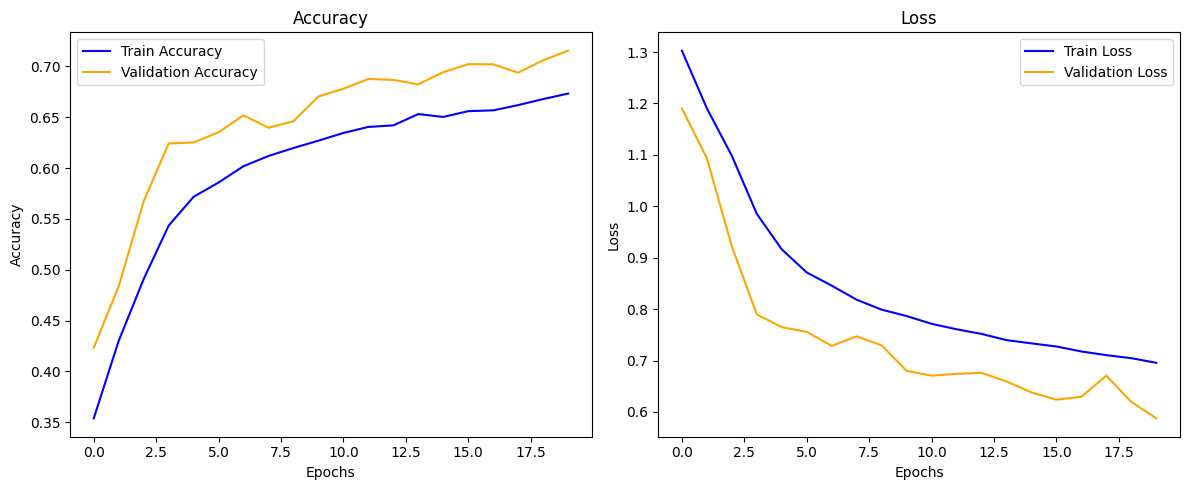

In [15]:
import matplotlib.pyplot as plt

# Plot the training history
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


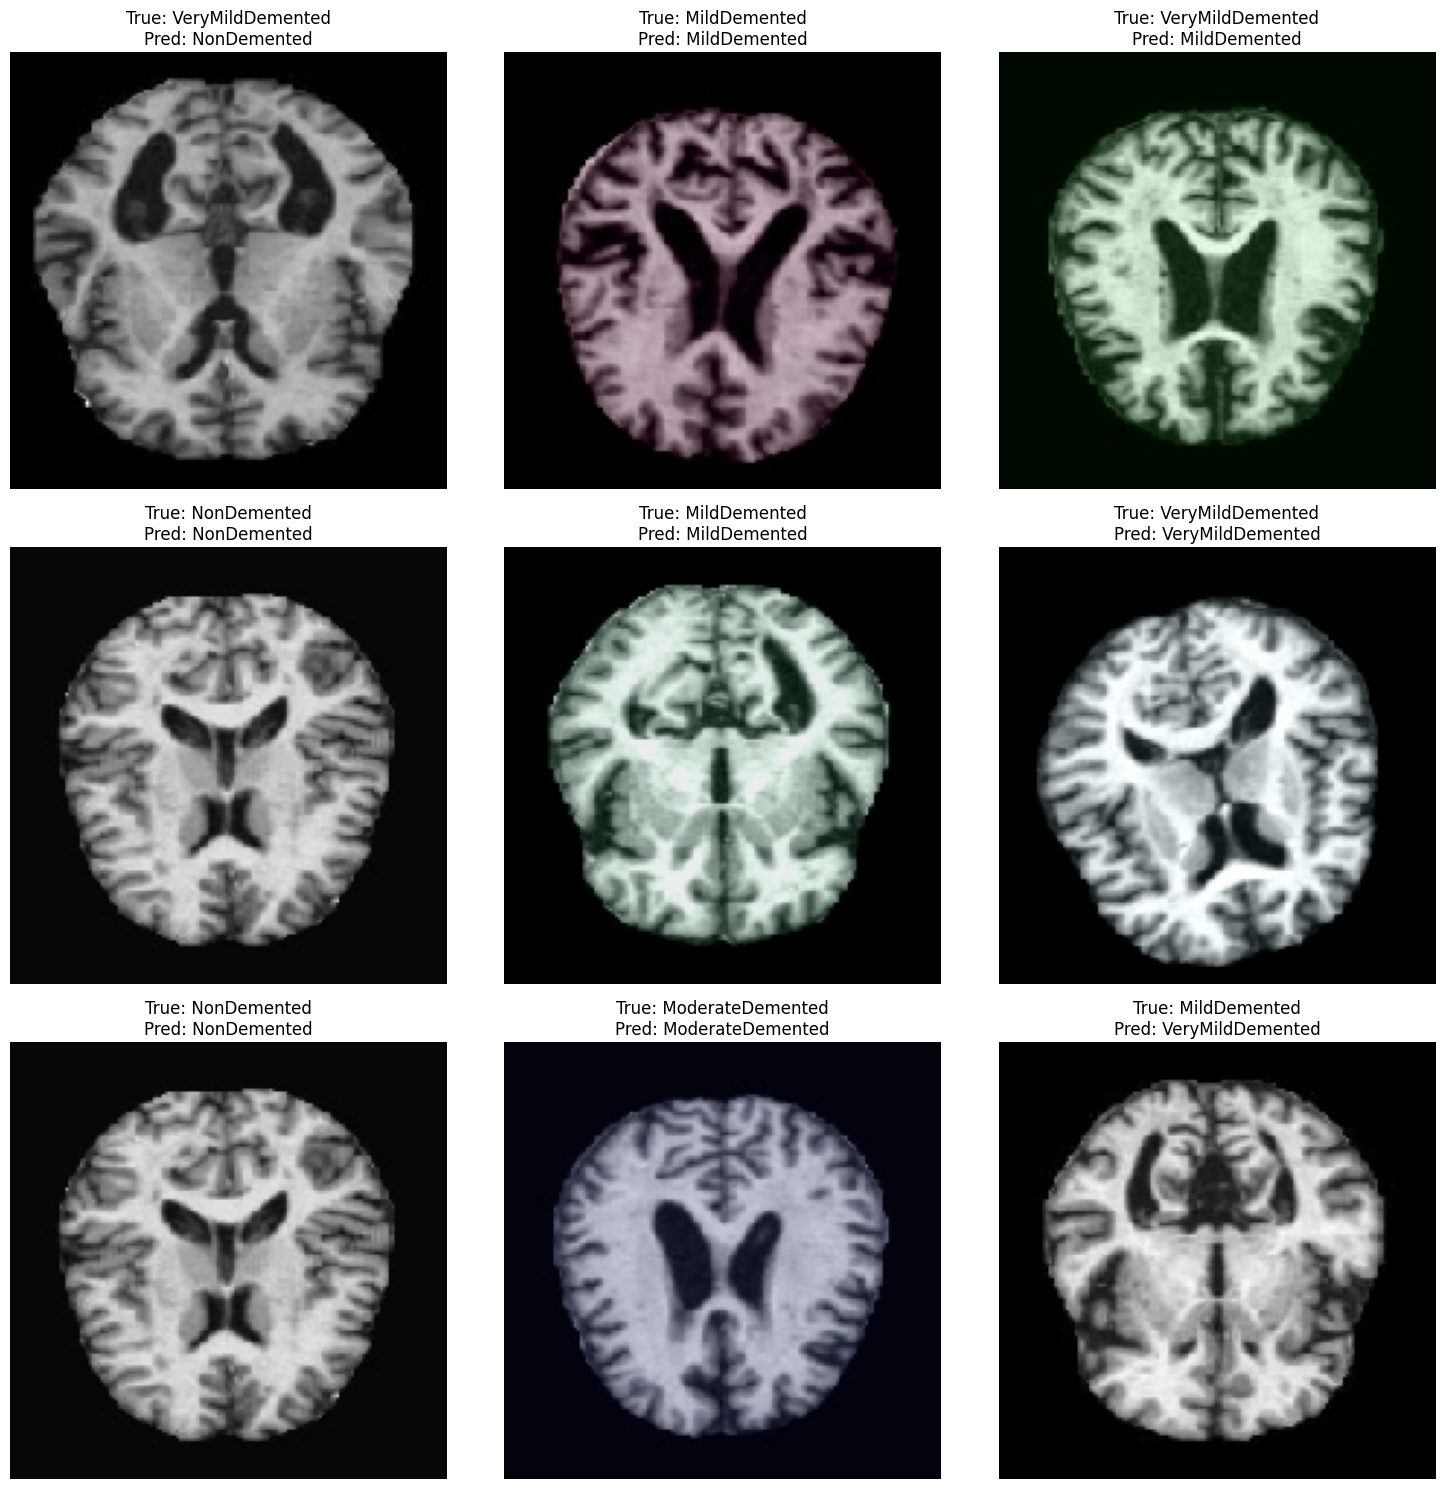

In [16]:
import numpy as np

def visualize_predictions(generator, model, class_labels, num_samples=9):
    plt.figure(figsize=(15, 15))

    # Get a batch of test images and labels
    x_test, y_test = next(generator)
    y_test = np.argmax(y_test, axis=1)  # True labels

    for i in range(num_samples):
        idx = np.random.randint(0, len(x_test))
        img = x_test[idx]
        true_label = class_labels[y_test[idx]]

        # Predict the label
        pred = model.predict(np.expand_dims(img, axis=0))
        pred_label = class_labels[np.argmax(pred)]

        # Plot the image with prediction
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Call the function
visualize_predictions(val_generator, model, class_labels)
